[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Rat_Individual_Overview.ipynb)

In [1]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

# numbers
import numpy as np
import pandas as pd

# sc
import anndata
import scanpy as sc

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from rat_friend import *

In [2]:
os.chdir('/home/coakes/rat/')

# Color Loading

In [3]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Collect Metadata from all OMIC files

In [5]:
omic_list =  ['RNA', 'ATAC', 'METHYL', 'ACETYL', 'PROT', 'PHOSPHO', 'UBIQ', 'METAB', 'IMMUNO']
for omic in omic_list:
    print(omic)
    adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
    if omic in ['RNA']:
        omic_pheno = adata.obs[['nid', 'tissue']]
        omic_pheno[omic] = 1
    else:
        temp_meta = adata.obs.reset_index(drop=True)[['nid', 'tissue']]
        temp_meta.tissue = temp_meta.tissue.str.upper()
        temp_meta[omic] = 1
        omic_pheno = pd.merge(omic_pheno, temp_meta, how = 'outer', on = ['nid', 'tissue'])
omic_pheno = omic_pheno.fillna(0)
omic_pheno = omic_pheno.replace(['TESTES', 'OVARY'], 'TESTES/OVARY')
omic_pheno

RNA


/tmp/ipykernel_1860714/4168027969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omic_pheno[omic] = 1


ATAC
METHYL
ACETYL
PROT
PHOSPHO
UBIQ
METAB
IMMUNO


,nid,tissue,RNA,ATAC,METHYL,ACETYL,PROT,PHOSPHO,UBIQ,METAB,IMMUNO
0,F0A,ADRNL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,F0A,BAT,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,F0A,BLOOD,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F0A,COLON,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,F0A,CORTEX,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1060,M8L,ADRNL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1061,M8L,BAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1062,M8L,PLASMA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1063,M8M,BAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Compress to by-individual

In [7]:
sum_omic_pheno = omic_pheno[['nid']+omic_list].groupby(['nid']).sum().reset_index()#/18

sum_omic_pheno = sum_omic_pheno[sum_omic_pheno.RNA > 0].reset_index(drop=True)
sum_omic_pheno.sort_values(['nid'])

,nid,RNA,ATAC,METHYL,ACETYL,PROT,PHOSPHO,UBIQ,METAB,IMMUNO
0,F0A,18.0,8.0,8.0,2.0,6.0,6.0,2.0,18.0,16.0
1,F0C,18.0,8.0,8.0,2.0,7.0,7.0,2.0,18.0,16.0
2,F0E,16.0,8.0,8.0,2.0,6.0,6.0,2.0,18.0,16.0
3,F0K,18.0,8.0,8.0,2.0,7.0,7.0,2.0,18.0,16.0
4,F0L,17.0,8.0,8.0,2.0,7.0,7.0,2.0,18.0,16.0
5,F1A,17.0,8.0,8.0,1.0,6.0,6.0,2.0,18.0,16.0
6,F1F,16.0,8.0,8.0,2.0,7.0,7.0,2.0,18.0,16.0
7,F1I,17.0,8.0,8.0,2.0,7.0,7.0,2.0,18.0,16.0
8,F1L,17.0,8.0,8.0,2.0,7.0,7.0,1.0,18.0,16.0
9,F1N,16.0,8.0,8.0,2.0,7.0,7.0,2.0,18.0,16.0


## Plot Results by individual

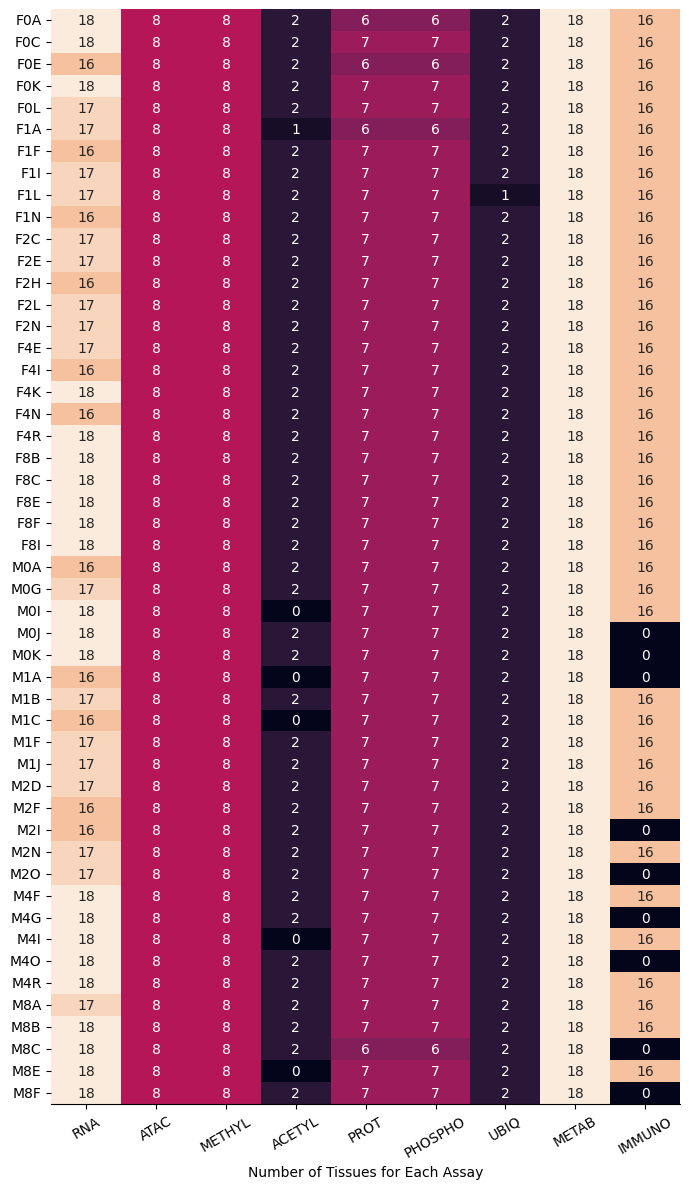

In [9]:
plt.figure(figsize=(7, 12))
#plt.figure(figsize=(25, 25))
g = sns.heatmap(sum_omic_pheno.sort_values(['nid'])[
            omic_list], 
            cbar = False,
            yticklabels = sum_omic_pheno.sort_values(['nid'])[
            'nid'],
           annot = True)
sns.despine(left=True)
plt.xticks(rotation=30)
plt.xlabel('Number of Tissues for Each Assay')
plt.tight_layout()
plt.savefig('figures_final/fig_1ab.png', pad_inches=0)

## Plot results by Tissue

In [10]:
sum_tissue_pheno = omic_pheno[['tissue', 'nid']+omic_list]

df1 = sum_tissue_pheno[[x[0] == 'M' for x in sum_tissue_pheno.nid.values]]
df1 = df1.drop('nid', axis=1).groupby(['tissue']).sum().reset_index()#/18
df1 = df1[df1.RNA > 0].reset_index(drop=True).add_suffix('_F')

df2 = sum_tissue_pheno[[x[0] == 'F' for x in sum_tissue_pheno.nid.values]]
df2 = df2.drop('nid', axis=1).groupby(['tissue']).sum().reset_index()#/18
df2 = df2[df2.RNA > 0].reset_index(drop=True).add_suffix('_M')

df3 = pd.concat([df1, df2], axis=1)
df3 = df3[[item for items in zip(df1.columns, df2.columns) for item in items]]
df3

,tissue_F,tissue_M,RNA_F,RNA_M,ATAC_F,ATAC_M,METHYL_F,METHYL_M,ACETYL_F,ACETYL_M,PROT_F,PROT_M,PHOSPHO_F,PHOSPHO_M,UBIQ_F,UBIQ_M,METAB_F,METAB_M,IMMUNO_F,IMMUNO_M
0,ADRNL,ADRNL,25.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,28.0,24.0,33.0
1,BAT,BAT,25.0,24.0,25.0,25.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,28.0,21.0,29.0
2,BLOOD,BLOOD,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COLON,COLON,24.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,16.0,25.0
4,CORTEX,CORTEX,24.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,30.0,30.0,30.0,0.0,0.0,26.0,28.0,19.0,29.0
5,HEART,HEART,25.0,24.0,25.0,25.0,25.0,25.0,24.0,30.0,30.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,19.0,29.0
6,HIPPOC,HIPPOC,25.0,24.0,25.0,25.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,16.0,25.0
7,HYPOTH,HYPOTH,24.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
8,KIDNEY,KIDNEY,24.0,25.0,25.0,25.0,25.0,25.0,0.0,0.0,30.0,30.0,30.0,30.0,0.0,0.0,26.0,28.0,19.0,29.0
9,LIVER,LIVER,24.0,25.0,25.0,25.0,25.0,25.0,24.0,29.0,30.0,29.0,30.0,29.0,30.0,30.0,26.0,28.0,19.0,29.0


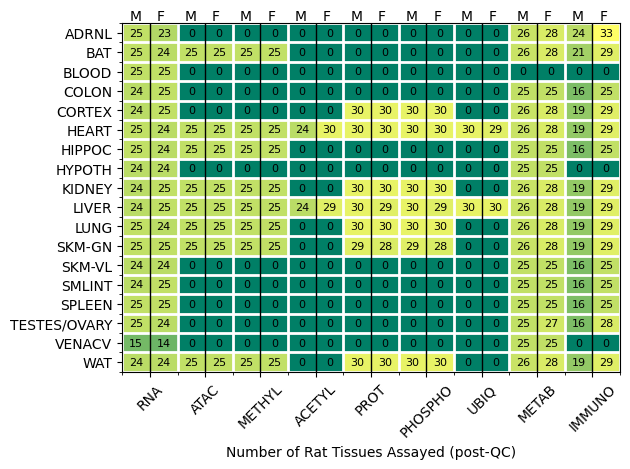

In [11]:
# Arrange alternate columns with data from channel S and A
data = np.array(df3)[:, 2:].astype('int')

x = df3.columns[2:].tolist()
y = df3['tissue_F'].tolist()

fig, ax = plt.subplots()
im = ax.imshow(data, cmap='summer')

# set xlabels
ax.set_xticks(list(np.arange(0.5, len(x)+.5, 2)))
ax.set_xticklabels([x[:-2] for x in x][::2], rotation=45)

# set ylabels
ax.set_yticks(list(range(0, len(y), 1)))
ax.set_yticklabels(y)

# white grid
ax.set_xticks(np.arange(-0.5, len(x), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(y), 1), minor=True)
ax.grid(which='minor', axis='both', 
linestyle='-', color='white', linewidth=2)

for i in range(0, len(x), 2):
    ax.text(-0.25 + i , -0.65, "M")
    ax.axvline(i + 0.5, lw=1, color='black', linewidth=0.7)
    ax.text(0.75 + i , -0.65, "F")

for i in range(len(x)):
    for j in range(len(y)):
        text = ax.text(j, i, data[i, j],
                       ha="center", va="center", color="black", size = 8)

ax.set_aspect('auto')
plt.xlabel('Number of Rat Tissues Assayed (post-QC)')
plt.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_1.png')